Before you turn in the homework, make sure everything runs as expected. To do so, select **Kernel**$\rightarrow$**Restart & Run All** in the toolbar above.  Remember to submit both on **DataHub** and **Gradescope**.

Please fill in your name and include a list of your collaborators below.

In [36]:
NAME = "Riley Campbell"
COLLABORATORS = ""

---

# Project 2: NYC Taxi Rides
# Part 3: NYC Accidents Data

In the real world, data isn't always nicely bundled in one file; data can be sourced from many places with many formats. Now we will use NYC accident data to try to improve our set of features.

In this part of the project, you'll do some EDA over the combined data set. We'll do a lot of the coding work for you, but there will be a few coding subtasks for you to complete on your own, as well as many results to interpret.

### Note
If your kernel dies unexpectedly, make sure you have shutdown all other notebooks. Each notebook uses valuable memory which we will need for this part of the project.

# Imports

Let us start by loading the Python libraries and custom tools we will use in this part.  

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from pathlib import Path

sns.set(style="whitegrid", palette="muted")

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

%matplotlib inline

## Downloading the Data

We will use the `fetch_and_cache` utility to download the dataset.

In [38]:
# Download and cache urls and get the file objects.
from utils import fetch_and_cache
data_url = 'https://github.com/DS-100/fa18/raw/gh-pages/assets/datasets/collisions.zip'
file_name = 'collisions.zip'
dest_path = fetch_and_cache(data_url=data_url, file=file_name)

print(f'Located at {dest_path}')

Using version already downloaded: Tue Dec  4 15:34:17 2018
MD5 hash of file: a445b925d24f319cb60bd3ace6e4172b
Located at data/collisions.zip


We will store the taxi data locally before loading it.

In [39]:
collisions_zip = zipfile.ZipFile(dest_path, 'r')

#Extract zip files 
collisions_dir = Path('data/collisions')
collisions_zip.extractall(collisions_dir)

## Loading and Formatting Data 

The following code loads the collisions data into a Pandas DataFrame.

In [40]:
# Run this cell to load the collisions data. 
skiprows = None
collisions = pd.read_csv(collisions_dir/'collisions_2016.csv', index_col='UNIQUE KEY', 
                         parse_dates={'DATETIME':["DATE","TIME"]}, skiprows=skiprows)
collisions['TIME'] = pd.to_datetime(collisions['DATETIME']).dt.hour
collisions['DATE'] = pd.to_datetime(collisions['DATETIME']).dt.date
collisions = collisions.dropna(subset=['LATITUDE', 'LONGITUDE'])
collisions = collisions[collisions['LATITUDE'] <= 40.85]
collisions = collisions[collisions['LATITUDE'] >= 40.63]
collisions = collisions[collisions['LONGITUDE'] <= -73.65]
collisions = collisions[collisions['LONGITUDE'] >= -74.03]
collisions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116691 entries, 3589202 to 3363795
Data columns (total 30 columns):
DATETIME                         116691 non-null datetime64[ns]
Unnamed: 0                       116691 non-null int64
BOROUGH                          100532 non-null object
ZIP CODE                         100513 non-null float64
LATITUDE                         116691 non-null float64
LONGITUDE                        116691 non-null float64
LOCATION                         116691 non-null object
ON STREET NAME                   95914 non-null object
CROSS STREET NAME                95757 non-null object
OFF STREET NAME                  61545 non-null object
NUMBER OF PERSONS INJURED        116691 non-null int64
NUMBER OF PERSONS KILLED         116691 non-null int64
NUMBER OF PEDESTRIANS INJURED    116691 non-null int64
NUMBER OF PEDESTRIANS KILLED     116691 non-null int64
NUMBER OF CYCLIST INJURED        116691 non-null int64
NUMBER OF CYCLIST KILLED         116691 

## 1: EDA of Accidents

Let's start by plotting the latitude and longitude where accidents occur. This may give us some insight on taxi ride durations. We sample N times (given) from the collisions dataset and create a 2D KDE plot of the longitude and latitude. We make sure to set the x and y limits according to the boundaries of New York, given below.

Here is a [map of Manhattan](https://www.google.com/maps/place/Manhattan,+New+York,+NY/@40.7590402,-74.0394431,12z/data=!3m1!4b1!4m5!3m4!1s0x89c2588f046ee661:0xa0b3281fcecc08c!8m2!3d40.7830603!4d-73.9712488) for your convenience.

/Users/rileycampbell/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


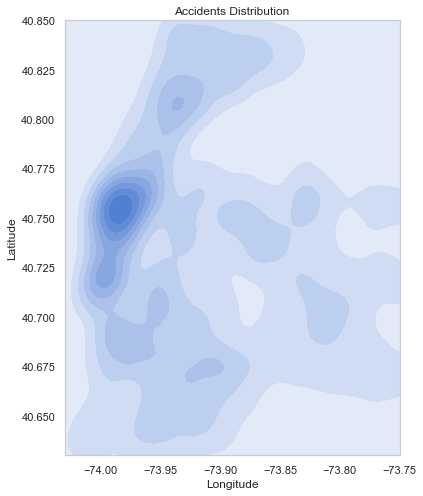

In [41]:
# Plot lat/lon of accidents, will take a few seconds
N = 20000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

sample = collisions.sample(N)
plt.figure(figsize=(6,8))
sns.kdeplot(sample["LONGITUDE"], sample["LATITUDE"], shade=True)
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Accidents Distribution")
plt.show();

### Question 1a
What can you say about the location density of NYC collisions based on the plot above?

**Hint: Here is a [page](https://www.google.com/maps/place/Manhattan,+New+York,+NY/@40.7590402,-74.0394431,12z/data=!3m1!4b1!4m5!3m4!1s0x89c2588f046ee661:0xa0b3281fcecc08c!8m2!3d40.7830603!4d-73.9712488) that may be useful, and [another page](https://www.6sqft.com/what-nycs-population-looks-like-day-vs-night/) that may be useful.**

In [42]:
q1a_answer = r"""

The collisions are most dense in midtown manhattan then there are several other areas where collisions are somewhat less dense like South Bronx. According to the article the north and south manhattan are most dense in population during the day then the density moves north at night. This could account for the accident distribution.

"""

# YOUR CODE HERE
# raise NotImplementedError()

print(q1a_answer)



The collisions are most dense in midtown manhattan then there are several other areas where collisions are somewhat less dense like South Bronx. According to the article the north and south manhattan are most dense in population during the day then the density moves north at night. This could account for the accident distribution.




We see that an entry in accidents contains information on number of people injured/killed. Instead of using each of these columns separately, let's combine them into one column called `'SEVERITY'`. Let's also make columns `FATALITY` and `INJURY`, each aggregating the fatalities and injuries respectively.

In [43]:
collisions['SEVERITY'] = collisions.filter(regex=r'NUMBER OF *').sum(axis=1)
collisions['FATALITY'] = collisions.filter(regex=r'KILLED').sum(axis=1)
collisions['INJURY'] = collisions.filter(regex=r'INJURED').sum(axis=1)

Now let's group by time and compare two aggregations: count vs mean. Below we plot the number of collisions and the mean severity of collisions by the hour, i.e. the `TIME` column. We visualize them side by side and set the start of our day to be 6 a.m.

Let's also take a look at the mean number of casualties per hour and the mean number of injuries per hour, plotted below.

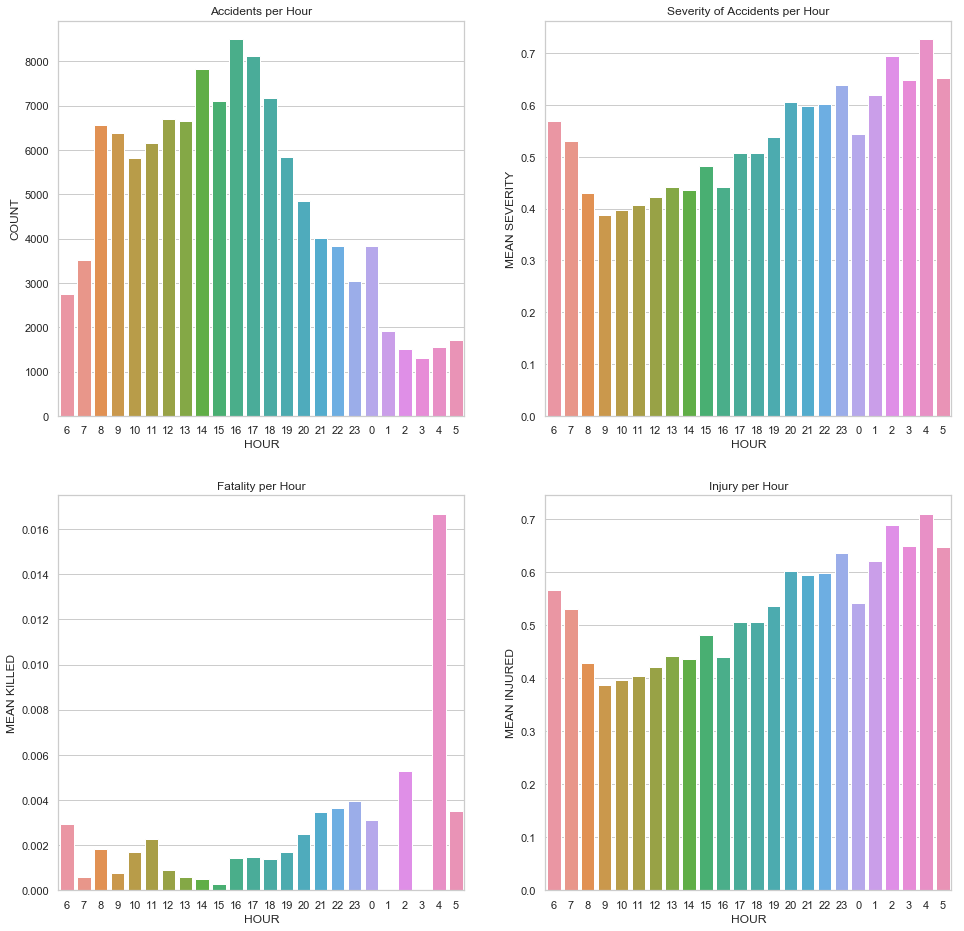

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(16,16))
order = np.roll(np.arange(24), -6)
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]

collisions_count = collisions.groupby('TIME').count()
collisions_count = collisions_count.reset_index()
sns.barplot(x='TIME', y='SEVERITY', data=collisions_count, order=order, ax=ax1)
ax1.set_title("Accidents per Hour")
ax1.set_xlabel("HOUR")
ax1.set_ylabel('COUNT')


collisions_mean = collisions.groupby('TIME').mean()
collisions_mean = collisions_mean.reset_index()
sns.barplot(x='TIME', y='SEVERITY', data=collisions_mean, order=order, ax=ax2)
ax2.set_title("Severity of Accidents per Hour")
ax2.set_xlabel("HOUR")
ax2.set_ylabel('MEAN SEVERITY')

fatality_count = collisions.groupby('TIME').mean()
fatality_count = fatality_count.reset_index()
sns.barplot(x='TIME', y='FATALITY', data=fatality_count, order=order, ax=ax3)
ax3.set_title("Fatality per Hour")
ax3.set_xlabel("HOUR")
ax3.set_ylabel('MEAN KILLED')

injury_count = collisions.groupby('TIME').mean()
injury_count = injury_count.reset_index()
sns.barplot(x='TIME', y='INJURY', data=injury_count, order=order, ax=ax4)
ax4.set_title("Injury per Hour")
ax4.set_xlabel("HOUR")
ax4.set_ylabel('MEAN INJURED')

plt.show();

### Question 1b
Based on the visualizations above, what can you say about each? Make a comparison between the accidents per hour vs the mean severity per hour. What about the number of fatalities per hour vs the number of injuries per hour? Why do we chose to have our hours start at 6 as opposed to 0?

In [45]:
q1b_answer = r"""

There are more accidents focused around rush hour. The severity of these accidents is worse away from rush hour so very early in the morning and very late at night. The most deaths occur at the very early hours in the morning and the injury rate is centered around late night hours/early morning. When the accidents per hour is high the severity is low and vice versa. The fatalities per hour vs the number of injuries per hour appear to follow similar distributions. There may be more fatalities at night and early morning from people getting hit by cars that can't see them in the dark. I predict that there are more accidents during rush hours because there are more cars on the road but these accidents are not as severe because the concentration of cars means slower speeds. So when there are less cars on the road late at night or very early in the morning cars can go faster and have more severe accidents. We choose to start these plots at 6 as opposed to 0 because that is when the work day starts and more accurately reflects the time when people begin and end their day. 

"""

# YOUR CODE HERE
# raise NotImplementedError()

print(q1b_answer)



There are more accidents focused around rush hour. The severity of these accidents is worse away from rush hour so very early in the morning and very late at night. The most deaths occur at the very early hours in the morning and the injury rate is centered around late night hours/early morning. When the accidents per hour is high the severity is low and vice versa. The fatalities per hour vs the number of injuries per hour appear to follow similar distributions. There may be more fatalities at night and early morning from people getting hit by cars that can't see them in the dark. I predict that there are more accidents during rush hours because there are more cars on the road but these accidents are not as severe because the concentration of cars means slower speeds. So when there are less cars on the road late at night or very early in the morning cars can go faster and have more severe accidents. We choose to start these plots at 6 as opposed to 0 because that is when the work da

Let's also check the relationship between location and severity. We provide code to visualize a heat map of collisions, where the x and y coordinate are the location of the collision and the heat color is the severity of the collision. Again, we sample N points to speed up visualization. 

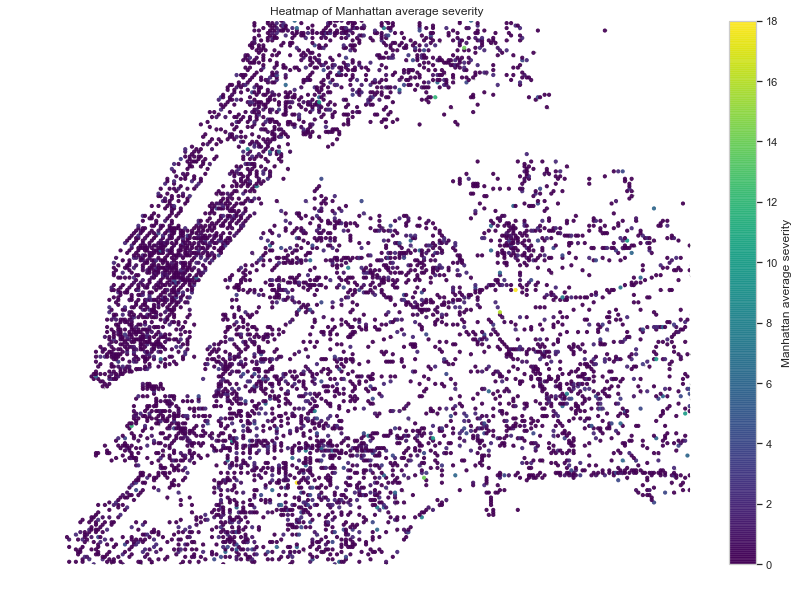

In [11]:
N = 10000
sample = collisions.sample(N)

# Round / bin the latitude and longitudes
sample['lat_bin'] = np.round(sample['LATITUDE'], 3)
sample['lng_bin'] = np.round(sample['LONGITUDE'], 3)

# Average severity for regions
gby_cols = ['lat_bin', 'lng_bin']

coord_stats = (sample.groupby(gby_cols)
               .agg({'SEVERITY': 'mean'})
               .reset_index())

# Visualize the average severity per region
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 10))

scatter_trips = ax.scatter(sample['LONGITUDE'].values,
                           sample['LATITUDE'].values,
                           color='grey', s=1, alpha=0.5)

scatter_cmap = ax.scatter(coord_stats['lng_bin'].values,
                          coord_stats['lat_bin'].values,
                          c=coord_stats['SEVERITY'].values,
                          cmap='viridis', s=10, alpha=0.9)

cbar = fig.colorbar(scatter_cmap)
cbar.set_label("Manhattan average severity")
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Heatmap of Manhattan average severity')
plt.axis('off');

### Question 1c
Do you think the location of the accident has a significant impact on the severity based on the visualization above? Additionally, identify something that could be improved in the plot above and describe how we could improve it.

In [46]:
q1c_answer = r"""

Based off this plot the location doesn't obviously appear to have an impact on severity. There are too many dark dots plotted for you to see a significant contrast. I also looked into the data and noticed that the vast majority of the accidents have a very low severity so the data is heavily skewed. This plot could be improved if we just visualized less severe accidents together. We could look at accidents with severity between 0 and 3, this would allow us to see more contrast in the plot and have it be more informative.


"""

# YOUR CODE HERE
# raise NotImplementedError()

print(q1c_answer)



Based off this plot the location doesn't obviously appear to have an impact on severity. There are too many dark dots plotted for you to see a significant contrast. I also looked into the data and noticed that the vast majority of the accidents have a very low severity so the data is heavily skewed. This plot could be improved if we just visualized less severe accidents together. We could look at accidents with severity between 0 and 3, this would allow us to see more contrast in the plot and have it be more informative.





### Question 1d
Create a plot to visualize one or more features of the `collisions` table. 

Text(20.325,0.5,'COUNT')

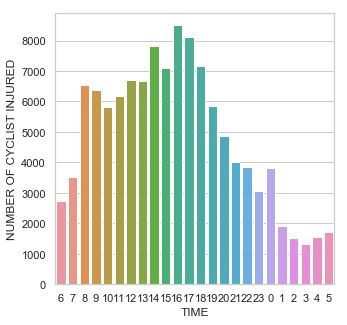

In [47]:
collisions['NUMBER OF CYCLIST INJURED']

fig, axes = plt.subplots(1, 1, figsize=(5,5))
order = np.roll(np.arange(24), -6)


collisions_count = collisions.groupby('TIME').count()
collisions_count = collisions_count.reset_index()
sns.barplot(x='TIME', y='NUMBER OF CYCLIST INJURED', data=collisions_count, order=order)
ax1.set_title("Cyclist per Hour")
ax1.set_xlabel("HOUR")
ax1.set_ylabel('COUNT')

### Question 1e
Answer the following questions regarding your plot in 1d.
1. What feature you're visualization
2. Why you chose this feature
3. Why you chose this visualization method

In [48]:
q1e_answer = r"""

1. I am visualizing the number of cyclists injured every hour. 
2. I chose this feature because I had a feeling that the cyclist injuries would heavily depend upon how many cars are on the road or at least how the cars would be interacting with the cyclists.
3. This visualization method allows you to see the clear distribution of cyclist over time.

"""
# YOUR CODE HERE
# raise NotImplementedError()
print(q1e_answer)



1. I am visualizing the number of cyclists injured every hour. 
2. I chose this feature because I had a feeling that the cyclist injuries would heavily depend upon how many cars are on the road or at least how the cars would be interacting with the cyclists.
3. This visualization method allows you to see the clear distribution of cyclist over time.




## 2: Combining External Datasets
It seems like accident timing and location may influence the duration of a taxi ride. Let's start to join our NYC Taxi data with our collisions data. 

Let's assume that an accident will influence traffic in the surrounding area for around 1 hour. Below, we create two columns, `START` and `END`:
- `START`: contains the recorded time of the accident
- `END`: 1 hours after `START`

**Note:** We chose 1 hour somewhat arbitrarily, feel free to experiment with other time intervals outside this notebook.

In [49]:
collisions['START'] = collisions['DATETIME']
collisions['END'] = collisions['START'] + pd.Timedelta(hours=1)

### Question 2a
Drop all of the columns besides the following: `DATETIME`, `TIME`, `START`, `END`, `DATE`, `LATITUDE`, `LONGITUDE`, `SEVERITY`. Feel free to experiment with other subsets outside of this notebook.

In [50]:
collisions_subset = collisions[['DATETIME', 'TIME', 'START','END','DATE','LATITUDE','LONGITUDE','SEVERITY']]
# YOUR CODE HERE
# raise NotImplementedError()
collisions_subset.head(5)

,DATETIME,TIME,START,END,DATE,LATITUDE,LONGITUDE,SEVERITY
UNIQUE KEY,,,,,,,,
3589202,2016-12-29 00:00:00,0,2016-12-29 00:00:00,2016-12-29 01:00:00,2016-12-29,40.844107,-73.897997,0
3587413,2016-12-26 14:30:00,14,2016-12-26 14:30:00,2016-12-26 15:30:00,2016-12-26,40.692347,-73.881778,0
3578151,2016-11-30 22:50:00,22,2016-11-30 22:50:00,2016-11-30 23:50:00,2016-11-30,40.755480,-73.741730,2
3567096,2016-11-23 20:11:00,20,2016-11-23 20:11:00,2016-11-23 21:11:00,2016-11-23,40.771122,-73.869635,0
3565211,2016-11-21 14:11:00,14,2016-11-21 14:11:00,2016-11-21 15:11:00,2016-11-21,40.828918,-73.838403,0


In [51]:
assert collisions_subset.shape == (116691, 8)

### Question 2b
Now, let's merge our `collisions_subset` table with `train_df`. Start by merging with only the date. We will filter by a time window in a later question.

We should be performing a left join, where our `train_df` is the left table. This is because we want to preserve all of the taxi rides in our end result. It happens that an inner join will also work, since both tables contain data on each date.

Note that the resulting `merged` table will have multiple rows for every taxi ride row in the original `train_df` table. For example, `merged` will have 483 rows with `index` equal to 16709, because there were 483 accidents that occurred on the same date as ride #16709.

Because of memory limitation, we will select the third week of 2016 to analyze. Feel free to change to it week 1 or 2 to see if the observation is general. 

In [52]:
data_file = Path("./", "cleaned_data.hdf")
train_df = pd.read_hdf(data_file, "train")
train_df = train_df.reset_index() 
train_df = train_df[['index', 'tpep_pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'duration']]
train_df['date'] = train_df['tpep_pickup_datetime'].dt.date

In [53]:
collisions_subset = collisions_subset[collisions_subset['DATETIME'].dt.weekofyear == 3]
train_df = train_df[train_df['tpep_pickup_datetime'].dt.weekofyear == 3]

In [54]:
# merge the dataframe here
merged = pd.merge(train_df, collisions_subset, left_on='date', right_on='DATE', how='left')

# YOUR CODE HERE
# raise NotImplementedError()

merged.head()

,index,tpep_pickup_datetime,pickup_longitude,pickup_latitude,duration,date,DATETIME,TIME,START,END,DATE,LATITUDE,LONGITUDE,SEVERITY
0,16709,2016-01-21 22:28:17,-73.997986,40.741215,736.0,2016-01-21,2016-01-21 10:35:00,10,2016-01-21 10:35:00,2016-01-21 11:35:00,2016-01-21,40.701651,-73.991484,0
1,16709,2016-01-21 22:28:17,-73.997986,40.741215,736.0,2016-01-21,2016-01-21 13:20:00,13,2016-01-21 13:20:00,2016-01-21 14:20:00,2016-01-21,40.704760,-74.014961,0
2,16709,2016-01-21 22:28:17,-73.997986,40.741215,736.0,2016-01-21,2016-01-21 16:00:00,16,2016-01-21 16:00:00,2016-01-21 17:00:00,2016-01-21,40.732891,-73.920574,4
3,16709,2016-01-21 22:28:17,-73.997986,40.741215,736.0,2016-01-21,2016-01-21 18:30:00,18,2016-01-21 18:30:00,2016-01-21 19:30:00,2016-01-21,40.714122,-73.831508,0
4,16709,2016-01-21 22:28:17,-73.997986,40.741215,736.0,2016-01-21,2016-01-21 00:05:00,0,2016-01-21 00:05:00,2016-01-21 01:05:00,2016-01-21,40.700108,-73.953819,0


In [55]:
assert merged.shape == (1528162, 14)

### Question 2c
Now that our tables are merged, let's use temporal and spatial proximity to condition on the duration of the average length of a taxi ride. Let's operate under the following assumptions.

Accidents only influence the duration of a taxi ride if the following are satisfied:

1) The haversine distance between the the pickup location of the taxi ride and location of the recorded accident is within 5 (km). This is roughly 3.1 miles.

2) The start time of a taxi ride is within a 1 hour interval between the start and end of an accident.

Complete the code below to create an `'accident_close'` column in the `merged` table that indicates if an accident was close or not according to the assumptions above.

In [56]:
def haversine(lat1, lng1, lat2, lng2):
    """
    Compute haversine distance
    """
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    average_earth_radius = 6371
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * average_earth_radius * np.arcsin(np.sqrt(d))
    return h

def manhattan_distance(lat1, lng1, lat2, lng2):
    """
    Compute Manhattan distance
    """
    a = haversine(lat1, lng1, lat1, lng2)
    b = haversine(lat1, lng1, lat2, lng1)
    return a + b

In [57]:
start_to_accident = haversine(merged['pickup_latitude'].values,
                              merged['pickup_longitude'].values,
                              merged['LATITUDE'].values,
                              merged['LONGITUDE'].values)
merged['start_to_accident'] = start_to_accident

# initialze accident_close column to all 0 first
merged['accident_close'] = 0

# Boolean pd.Series to select the indices for which accident_close should equal 1:
# (1) record's start_to_accident <= 5 
# (2) pick up time is between start and end    
is_accident_close = (merged['start_to_accident'] <= 5) & (merged['START'] <= merged['tpep_pickup_datetime']) & ( merged['tpep_pickup_datetime'] <= merged['END'])

# # YOUR CODE HERE
# # raise NotImplementedError()
# # is_accident_close
merged.loc[is_accident_close, 'accident_close'] = 1

In [58]:
assert merged['accident_close'].sum() > 16000

The last step is to aggregate the total number of proximal accidents. We want to count the total number of accidents that were close spatially and temporally and condition on that data. 

The code below create a new data frame called `train_accidents`, which is a copy of `train_df`, but with a new column that counts the number of accidents that were close (spatially and temporally) to the pickup location/time. 

In [59]:
train_df = train_df.set_index('index')
num_accidents = merged.groupby(['index'])['accident_close'].sum().to_frame()
train_accidents = train_df.copy()
train_accidents['num_accidents'] = num_accidents

Next, for each value of `num_accidents`, we plot the average `duration` of rides with that number of accidents.

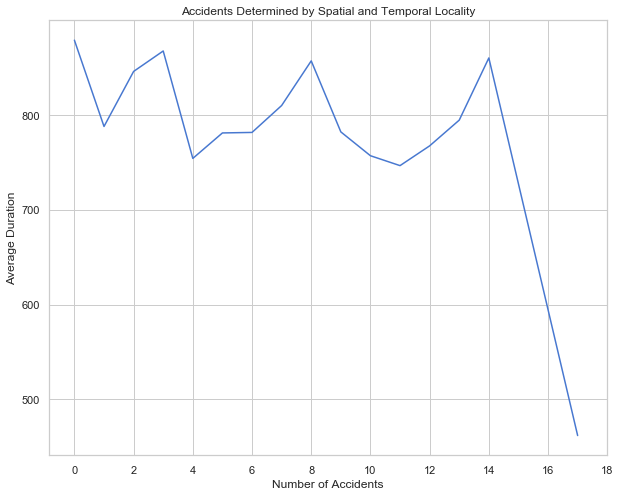

In [60]:
plt.figure(figsize=(10,8))
train_accidents.groupby('num_accidents')['duration'].mean().plot(xticks=np.arange(0, 20, 2))
plt.title("Accidents Determined by Spatial and Temporal Locality")
plt.xlabel("Number of Accidents")
plt.ylabel("Average Duration")
plt.show();

It seems that using both spatial and temporal proximity doesn't give us much insight on if collisions increase taxi ride durations. Let's try conditioning on spatial proximity and temporal proximity separately and see if there are more interesting results there.

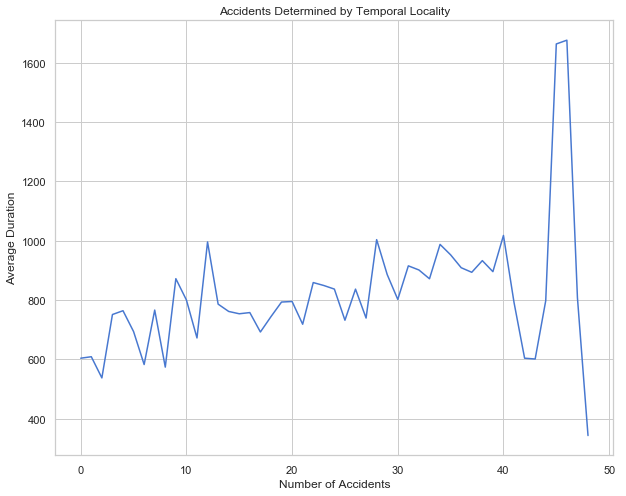

In [61]:
# Temporal locality

# Condition on time
index = (((merged['tpep_pickup_datetime'] >= merged['START']) & \
         (merged['tpep_pickup_datetime'] <= merged['END'])))

# Count accidents
merged['accident_close'] = 0
merged.loc[index, 'accident_close'] = 1
num_accidents = merged.groupby(['index'])['accident_close'].sum().to_frame()
train_accidents_temporal = train_df.copy()
train_accidents_temporal['num_accidents'] = num_accidents

# Plot
plt.figure(figsize=(10,8))
train_accidents_temporal.groupby('num_accidents')['duration'].mean().plot()
plt.title("Accidents Determined by Temporal Locality")
plt.xlabel("Number of Accidents")
plt.ylabel("Average Duration")
plt.show();

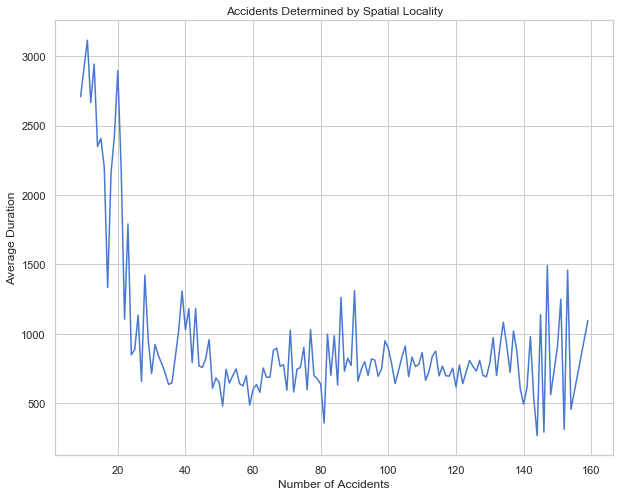

In [62]:
# Spatial locality

# Condition on space
index = (merged['start_to_accident'] <= 5)

# Count accidents
merged['accident_close'] = 0
merged.loc[index, 'accident_close'] = 1
num_accidents = merged.groupby(['index'])['accident_close'].sum().to_frame()
train_accidents_spatial = train_df.copy()
train_accidents_spatial['num_accidents'] = num_accidents

# Plot
plt.figure(figsize=(10,8))
train_accidents_spatial.groupby('num_accidents')['duration'].mean().plot()
plt.title("Accidents Determined by Spatial Locality")
plt.xlabel("Number of Accidents")
plt.ylabel("Average Duration")
plt.show();

### Question 2d
By conditioning on temporal and spatial proximity separately, we reveal different trends in average ride duration as a function of number of accidents nearby.

What can you say about the temporal and spatial proximity of accidents to taxi rides and the effect on ride duration? Think of a new hypothesis regarding accidents and taxi ride durations and explain how you would test it.

Additionally, comment on some of the assumptions being made when we condition on temporal and spatial proximity separately. What are the implications of only considering one and not the other? 

In [63]:
q2d_answer = r"""

It is clear from the temporal proximity of accidents and taxis that more accidents lead to higher average duration. This makes sense because even if a car gets in an accident far away from a taxi that taxi ride may have a higher duration due to the shut down of a major freeway if the accident is severe or just involves enough cars to close down or slow down a main road. It is hard to say anything about the spatial plot because although you know the accident happened nearby the taxi pick up you don't know if that accident happened at the same time and is still there. It is very possible that you have an accident at 8am then it is cleaned up by 10am and the duration for a taxi picking up in the same spot wouldn't be effected at 10pm.
When looking at both temporal and spatial proximity the plot is not clear however I hypothesize that if we adjust the start and end time of an accident we may get better results. I predict that a standard 1 hr start and end is not sufficient for all accidents, we could possibly have a longer start and end time for accidents that are more severe or involve more people. 

The assumptions you are making when you are looking at just time is that taking the mean of all taxi ride duration is skewed towards higher duration where there are more cars, the accidents though aren't neccessary concentrated where there are more cars. We tried to determine this in the previous plot but failed from overplotting. The assumption you are making about spatial proximity plot is that an accident in one place will effect duration of taxi rides when this is not the case for taxi rides that happen in the same place but hours later.


"""

# YOUR CODE HERE
# raise NotImplementedError()

print(q2d_answer)



It is clear from the temporal proximity of accidents and taxis that more accidents lead to higher average duration. This makes sense because even if a car gets in an accident far away from a taxi that taxi ride may have a higher duration due to the shut down of a major freeway if the accident is severe or just involves enough cars to close down or slow down a main road. It is hard to say anything about the spatial plot because although you know the accident happened nearby the taxi pick up you don't know if that accident happened at the same time and is still there. It is very possible that you have an accident at 8am then it is cleaned up by 10am and the duration for a taxi picking up in the same spot wouldn't be effected at 10pm.
When looking at both temporal and spatial proximity the plot is not clear however I hypothesize that if we adjust the start and end time of an accident we may get better results. I predict that a standard 1 hr start and end is not sufficient for all accide

## Part 3 Exports
We are not requiring you to export anything from this notebook, but you may find it useful to do so. There is a space below for you to export anything you wish.

In [29]:
Path("data/part3").mkdir(parents=True, exist_ok=True)
data_file = Path("data/part3", "data_part3.hdf") # Path of hdf file
...

Ellipsis

## Part 3 Conclusions

We merged the NYC Accidents dataset with our NYC Taxi dataset, conditioning on temporal and spatial locality. We explored potential features by visualizing the relationship between number of accidents and the average duration of a ride. 

**Please proceed to part 4 where we will be engineering more features and building our models using a processing pipeline.**

## Submission

You're almost done!

Before submitting this assignment, ensure that you have:

1. Restarted the Kernel (in the menubar, select Kernel$\rightarrow$Restart & Run All)
2. Validated the notebook by clicking the "Validate" button.

Then,

1. **Submit** the assignment via the Assignments tab in **Datahub** 
1. **Upload and tag** the manually reviewed portions of the assignment on **Gradescope**